In [47]:
import os
import re
import cv2
import random
import imutils
import math
import numpy as np
import pandas as pd
from typing import Any
from openpyxl import Workbook
from matplotlib import pyplot as plt
from paddleocr import PaddleOCR
from tensorflow.keras.preprocessing import image as tfimage
from trdg.generators import GeneratorFromStrings

In [13]:
# type decls
cv2.Image = np.ndarray
cv2.Contour = np.ndarray

# shows an image on ipynb
def imshow(img: cv2.Image) -> None:
    plt.axis('off')
    plt.grid(False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

def grayscale(img: cv2.Image) -> cv2.Image:
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Get all testing images into an array

In [38]:
DATASET_PATH = f'dataset'
IMAGE_LIMIT = 50

images = []
for (id, filename) in enumerate(os.listdir(DATASET_PATH)):
    if id == IMAGE_LIMIT:
        break
    image = cv2.imread(f"{DATASET_PATH}/{filename}")
    images.append((filename, image))

Defines image cropper to center the text in the image

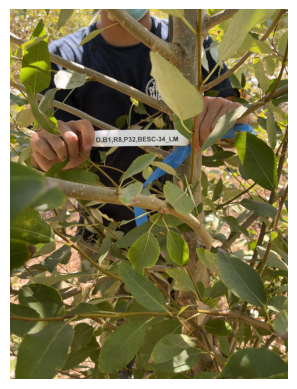

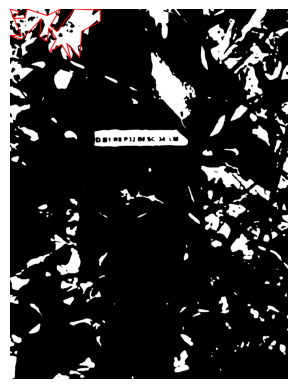

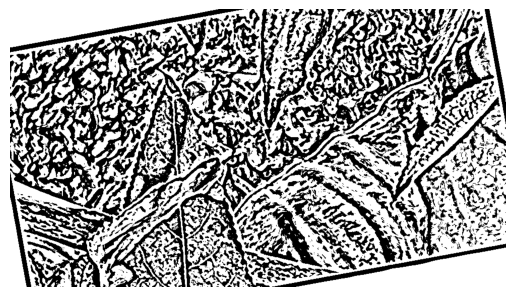

In [43]:
def process_image(img: cv2.Image, strength: int = 1) -> cv2.Image:
    gray = grayscale(img)
    blur = tfimage.img_to_array(cv2.medianBlur(gray, 5), dtype='uint8')
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, strength)
    return thresh

def get_largest_contour(img: cv2.Image) -> cv2.Contour:
    gray = grayscale(img)
    blur = cv2.GaussianBlur(gray, (51, 51), 0)
    thresh = cv2.threshold(blur, 150, 255, 0)[1]
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    return thresh, sorted(contours, key=cv2.contourArea, reverse=True)[0]

def crop_image(img: cv2.Image, debug: bool = False) -> cv2.Image:

    if debug: imshow(img)

    thresh, big_contour = get_largest_contour(img)
    x, y, w, h = cv2.boundingRect(big_contour)
    newimg = img[y:y+h, x:x+w]

    # perform 90-deg rotation if the cropped image is wider than tall
    if h > w: newimg = np.array([[newimg[j][i] for j in reversed(range(len(newimg)))] for i in range(len(newimg[0]))])

    # get the longest line in the approximation
    newimg_thresh, newimg_big_contour = get_largest_contour(newimg)
    approx = cv2.approxPolyDP(newimg_big_contour, 0.010*cv2.arcLength(newimg_big_contour, True), True)
    simplified_approx = list(map(lambda x: tuple(x[0]), approx))
    max_lines = sorted(
        zip(simplified_approx, simplified_approx[1:] + [simplified_approx[0]]),  # connects all the points with the adjacent one
        key=lambda l: (l[0][0]-l[1][0])**2 + (l[0][1]-l[1][1])**2                # distance formula
    )[-2:]

    def get_angle(line: tuple[tuple[int]]) -> float:

        # flatten the longest line, from / to __
        y_dist = line[0][1]-line[1][1]
        x_dist = line[0][0]-line[1][0]
        angle = math.degrees(math.atan(y_dist/x_dist))
        return angle

    if debug:
        drawn_contours = cv2.drawContours(cv2.cvtColor(thresh.copy(), cv2.COLOR_GRAY2BGR), [approx], -1, (0, 0, 255), 10)
        imshow(drawn_contours)
        
    newimg = imutils.rotate(newimg, angle=float(np.average([*map(get_angle, max_lines)])))

    return newimg

test_index = 0
img = crop_image(images[test_index][1], debug=True)
img = process_image(img)
imshow(img)

Generate synthetic data to train neural network

**NOT USED RIGHT NOW**

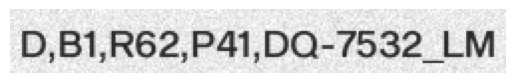

In [ ]:
ALPHABET = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
IMG_COUNT = 100
DATA_PATH = 'synthetic-data'
IMAGES_PATH = f'{DATA_PATH}/images'

os.system(f"{'rm -rf' if os.name != 'nt' else 'rmdir /s /q'} {DATA_PATH}")
os.system(f"mkdir {DATA_PATH} {IMAGES_PATH}")
os.system(f"echo '*' > {DATA_PATH}/.gitignore")

def get_random_text():
    treatment = random.choice(['C', 'D'])
    block = f"B{random.choice(['1', '2'])}"
    row = f"R{random.randint(1, 99)}"
    position = f"P{random.randint(1, 99)}"
    
    gen_length = random.randint(2, 4)
    num_count = random.choices([1, 2, 3], weights=(70, 15, 15))[0]
    num_lengths = random.choices([1, 2, 3, 4], weights=(15, 15, 15, 55), k=num_count)

    genotype = (
        "".join([ALPHABET[random.randint(0, 25)] for _ in range(gen_length)]) + 
        f"-{'-'.join([str(random.randint(10**(i-1), 10**i-1)) for i in num_lengths])}_LM"
    )

    return ','.join([treatment, block, row, position, genotype])

# generate the new images, limiting count
generator = GeneratorFromStrings(
    [get_random_text() for _ in range(1000)],
    random_blur=True,
    random_skew=True,
    fonts=['assets/image_font.ttf']
)
i = 0
for img, lbl in generator:
    if i == IMG_COUNT: break
    img.save(f'{IMAGES_PATH}/{lbl}_{i}.png')
    i += 1

# randomly selects one image for exemplary purposes
example_img = random.choice(os.listdir(IMAGES_PATH))
imshow(cv2.imread(f"{IMAGES_PATH}/{example_img}"))

 None 


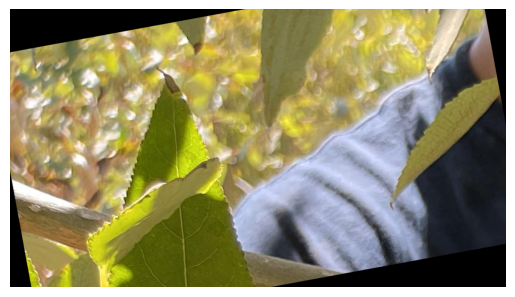

 C,B1,R10,P12,**BESC-417_LM** 
 None 


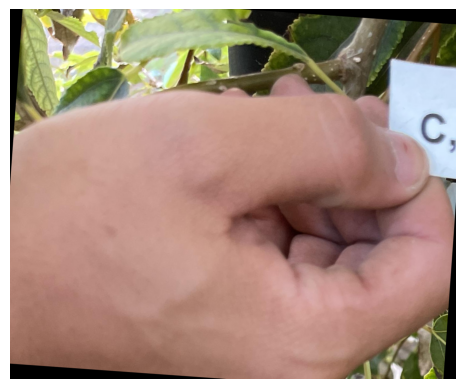

 C,B2,R6,P54,BESC-28LM 
 C,B1,R24,P22**LILD-26-5 LM** 
 55.*HOMD-21-2LM 
 C.B2,R23.P45.BESC-361 1611CB 
 C,B1,R25,P30,**BESC-106_LM**,cor 
 C,B1,R44,P4,**GW-9967 LM**,core 
 C,B2,R3,P41,SQMA-25-1 LM 
 None 


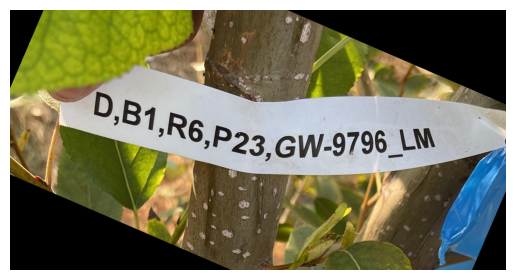

 None 


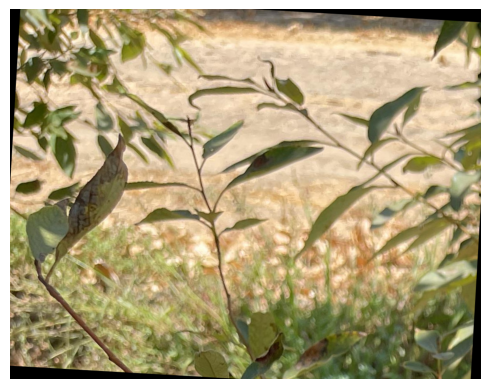

 None 


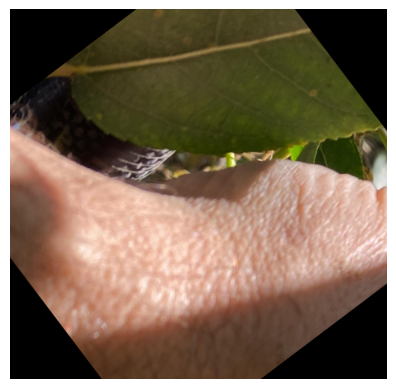

 C,B3,R37,P61,BESC-363 LM 
 None 


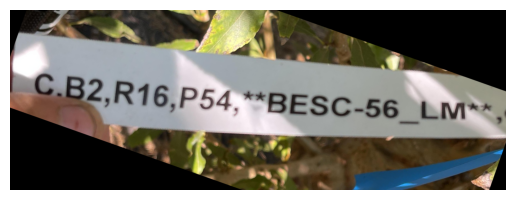

 B2 R28,P57,BESC-817 LM 
 C,B1,R15,P13,BESC-240_L 
 C,B1,R32,P27,**BESC-1236.37 15 CB* 
 C,B2,R26,P45,**BESC-151 LM**core 
 C,B2,R10,P55,GW-2887_WP 
 R16,P40,**BESC-212 LM**,core 
 D.B1,R6,P78,GW-9837_LM 
 C.B9.R3P35 
 C,B2,R23,P55,BESC-93_LM 
 C,B2,R12,P54,**GW-9969LM 
 None 


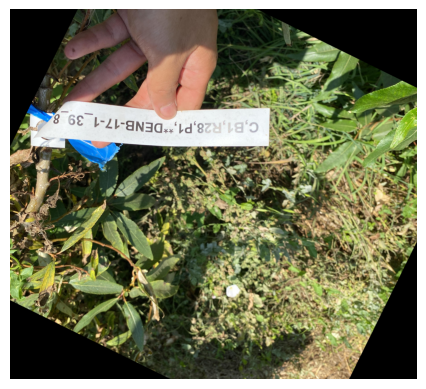

 None 


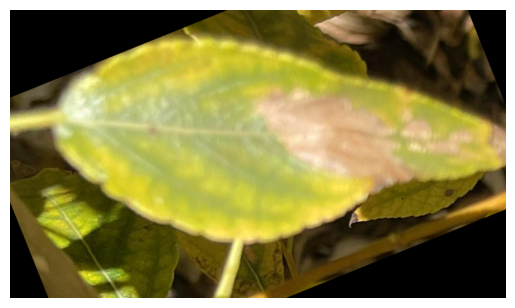

 None 


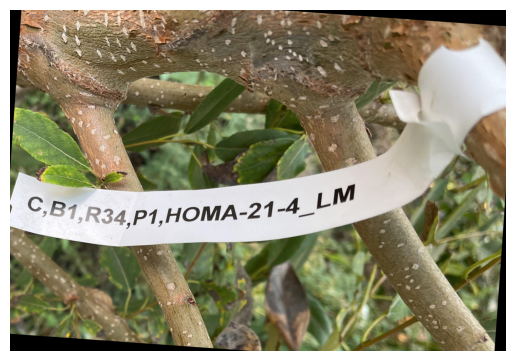

 D.B1.R32.GW-9833 LM 
 ,B1,R41,P30**GW-9859 WP** 
 None 


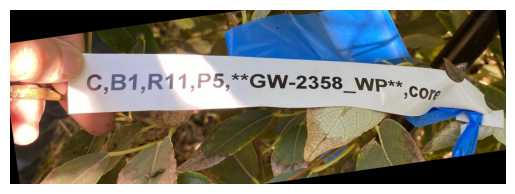

 C,B2,R25,P52,GW-9788 LM 
 D,B1,R5,P25,BESC-321 LM 
 B1,R1,P31**BESC-429LM**,core 
 B1,R1,P3**BESC-1175_35c 
 None 


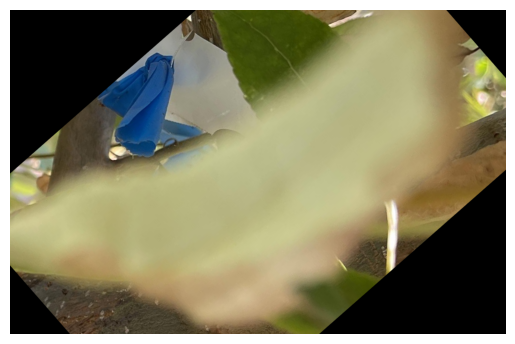

 D,B1,R6,P70,BESC-261 LM 
 C,B1,R13,P1,BESC-1214 36 12 CB 
 None 


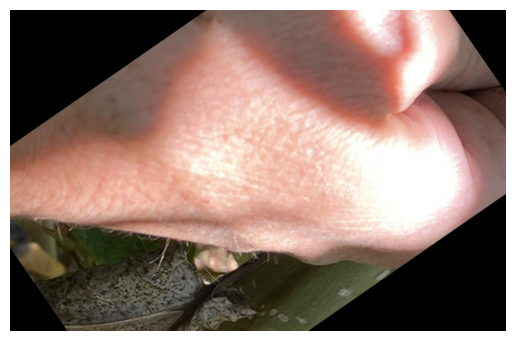

 None 


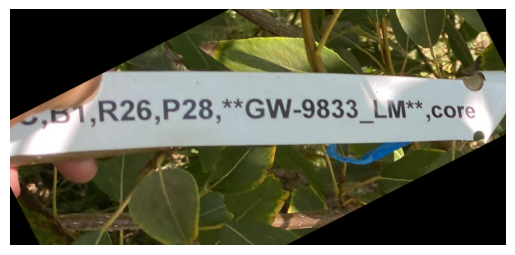

 None 


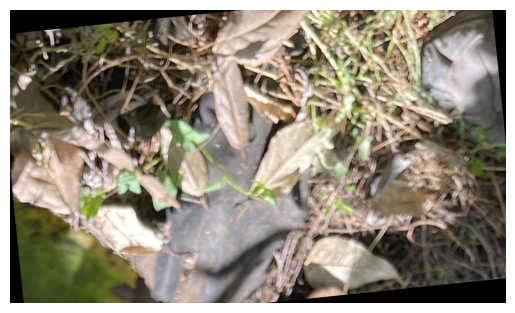

 None 


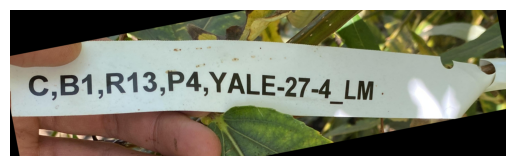

 B2,R23,P32,GW-9847_LM 
 2,R23,P46,GW-10982 LM 
 ,B1,R6,P25,GW-9582LM 
 D.B1,R6,P81.BESC-850 LM 
 C,B2,R21,P31,GW-11046_LM 
 C,B2,R33,P42.GW-2616_WP 
 2,R7,P61 **BESC-275_LM**,core 
 None 


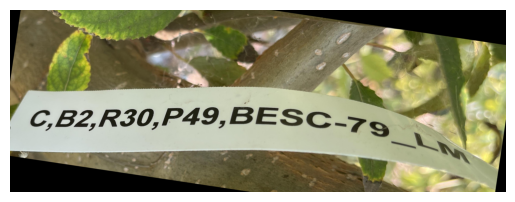

Texts not detected: 32.00%


In [41]:
PADDLE_OCR = PaddleOCR(use_angle_cls=True, lang='en', show_log=False, rotation=True)
SHOW_IMAGE = "text is None"

def get_text(text: Any, mode: str) -> str:
    if mode == "paddle":
        output = ""
        if text == [[]]:
            return None
        for item in sorted(text[0], key=lambda x: x[0][0]):
            output += item[1][0]
        if len(output) < 10:
             return None
        return output
    
cropped_images = map(lambda x: (x[0],  crop_image(x[1])), images)
ocr_texts = []
for filename, image in cropped_images:
    if (text:=get_text(PADDLE_OCR.ocr(image), mode="paddle")) is None:
        bw_image = process_image(image, strength=-2)
        text = get_text(PADDLE_OCR.ocr(bw_image), mode="paddle")
    ocr_texts.append((filename, text))
    print("\033[31m", text, "\033[0m")
    if eval(SHOW_IMAGE):
        imshow(image)

print(f"Texts not detected: {sum(map(lambda x: x[1] is None, ocr_texts))/len(ocr_texts):.2%}")

In [46]:
ocr_texts = np.array(ocr_texts)
print(ocr_texts)

[['EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg' None]
 ['5AF900F9-D701-4994-95AC-2352420BF18F.jpg'
  'C,B1,R10,P12,**BESC-417_LM**']
 ['F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg' None]
 ['9117861B-2D2B-4EA8-94B1-D0A862914398.jpg' 'C,B2,R6,P54,BESC-28LM']
 ['D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg'
  'C,B1,R24,P22**LILD-26-5 LM**']
 ['18CBB825-2DFB-41FD-80A7-976B6A7526AC.jpg' '55.*HOMD-21-2LM']
 ['281E6E62-E284-479D-AF86-09AAC2EEA749.jpg'
  'C.B2,R23.P45.BESC-361 1611CB']
 ['E3666414-68C0-4ACE-B882-FDC78306DE27.jpg'
  'C,B1,R25,P30,**BESC-106_LM**,cor']
 ['467EDEC9-6C89-4A2D-88CD-8393C398B6A0.jpg'
  'C,B1,R44,P4,**GW-9967 LM**,core']
 ['E67FBF2D-1010-43F0-BBB4-46A33A2369A0.jpg' 'C,B2,R3,P41,SQMA-25-1 LM']
 ['F299B9C8-562E-4A98-A0D1-28976578A7D0.jpg' None]
 ['F852C361-F6F6-4EF8-B908-79F6603ABC97.jpg' None]
 ['B03DCF6A-5191-49F2-9127-D41002A7108D.jpg' None]
 ['19D28FC3-ADB4-403E-AC41-4A774F482FCB.jpg' 'C,B3,R37,P61,BESC-363 LM']
 ['3172BCA6-386F-463F-A540-BBC2BDAF05C1.jpg' None]
 ['8B0A7311-

In [61]:
df_list = []
for (filename, text) in ocr_texts:

    df_row = {
        'filename': filename,
        'treatment': None,
        'block': None,
        'row': None,
        'position': None,
        'genotype': None
    }
    df_list.append(df_row)

    if text is None:
        continue

    # get block, row, position
    if (block:=re.search(r"B\d+", text)) is not None:
        df_row['block'] = int(block.group().replace('B', ''))
    if (position:=re.search(r"P\d+", text)) is not None:
        df_row['position'] = int(position.group().replace('P', ''))
    if (row:=re.search(r"R\d+", text)) is not None:
        df_row['row'] = int(row.group().replace('R', ''))

    # get treatment
    if text[0] in ['C', 'D']:
        df_row['treatment'] = text[0]

    # get genotype
    if (genotype:=re.search(r"[A-Z]{2,}(-\d+)+", text)) is not None:
        genotype = genotype.group()
        if '*' in text:
            genotype = f"**{genotype}**,core"
        df_row['genotype'] = genotype

df = pd.DataFrame(df_list)

In [62]:
df.head()

filename treatment  block   row  position  \
0  EB00CEE6-848F-4E2A-9A56-C0CD83D55630.jpg      None    NaN   NaN       NaN   
1  5AF900F9-D701-4994-95AC-2352420BF18F.jpg         C    1.0  10.0      12.0   
2  F7D01515-92CA-4AF5-9BD9-3A4CD99EDF42.jpg      None    NaN   NaN       NaN   
3  9117861B-2D2B-4EA8-94B1-D0A862914398.jpg         C    2.0   6.0      54.0   
4  D1B282CF-2A10-4458-9E3A-FE08E065A3D6.jpg         C    1.0  24.0      22.0   

             genotype  
0                None  
1   **BESC-417**,core  
2                None  
3             BESC-28  
4  **LILD-26-5**,core

In [63]:
EXAMPLE_DATA = pd.DataFrame({
    'filename': ['example1.png', 'example2.png'],
    'treatment': ['C', 'D'],
    'block': ['1', '2'],
    'row': ['54', '23'],
    'position': ['12', '10'],
    'genotype': ['BESC-4590_LM', 'BESC-4230_LM']
})

def make_sheet(data: pd.DataFrame, excel_file: str) -> None:
    wb = Workbook()
    worksheet = wb.active
    
    # For writing the Header Rows on Excel
    headers = [*data.keys()]
    worksheet.append(headers)

    # For writing the data rows for each image in the dataset
    for i in range(len(data)):
        row = [data[header][i] for header in headers]
        worksheet.append(row)

    wb.save(excel_file)
        
make_sheet(df, 'data.xlsx')